In [1]:
import torch
import argparse
import warnings
import numpy as np
import pandas as pd
from src.graph_func import graph_construction,combine_graph_dict
from src.utils_func import mk_dir, adata_preprocess, load_ST_file
import anndata
from src.SEDR_train import SEDR_Train
from sklearn import metrics
import matplotlib.pyplot as plt
import scanpy as sc
import os
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph as knn_g
import umap.umap_ as umap
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')
torch.cuda.cudnn_enabled = False
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
device='cpu'
print('===== Using device: ' + device)

===== Using device: cpu


In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--k', type=int, default=10, help='parameter k in spatial graph')
parser.add_argument('--knn_distanceType', type=str, default='euclidean',
                    help='graph distance type: euclidean/cosine/correlation')
parser.add_argument('--epochs', type=int, default=300, help='Number of epochs to train.')
parser.add_argument('--cell_feat_dim', type=int, default=300, help='Dim of PCA')
parser.add_argument('--feat_hidden1', type=int, default=100, help='Dim of DNN hidden 1-layer.')
parser.add_argument('--feat_hidden2', type=int, default=20, help='Dim of DNN hidden 2-layer.')
parser.add_argument('--gcn_hidden1', type=int, default=32, help='Dim of GCN hidden 1-layer.')
parser.add_argument('--gcn_hidden2', type=int, default=8, help='Dim of GCN hidden 2-layer.')
parser.add_argument('--p_drop', type=float, default=0.2, help='Dropout rate.')
parser.add_argument('--using_dec', type=bool, default=True, help='Using DEC loss.')
parser.add_argument('--using_mask', type=bool, default=True, help='Using mask for multi-dataset.')
parser.add_argument('--feat_w', type=float, default=10, help='Weight of DNN loss.')
parser.add_argument('--gcn_w', type=float, default=0.1, help='Weight of GCN loss.')
parser.add_argument('--dec_kl_w', type=float, default=10, help='Weight of DEC loss.')
parser.add_argument('--gcn_lr', type=float, default=0.01, help='Initial GNN learning rate.')
parser.add_argument('--gcn_decay', type=float, default=0.01, help='Initial decay rate.')
parser.add_argument('--dec_cluster_n', type=int, default=8, help='DEC cluster number.')
parser.add_argument('--dec_interval', type=int, default=20, help='DEC interval nnumber.')
parser.add_argument('--dec_tol', type=float, default=0.00, help='DEC tol.')
# ______________ Eval clustering Setting _________
parser.add_argument('--eval_resolution', type=int, default=1, help='Eval cluster number.')
parser.add_argument('--eval_graph_n', type=int, default=20, help='Eval graph kN tol.') 

params,unknown=parser.parse_known_args()
params.device = device

DLPFC

In [5]:
dirs="/data02/tguo/space_batch_effect/human_DLPFC_10x/"
sample_name=np.array(['151507','151508','151509','151510','151669','151670','151671','151672','151673','151674','151675','151676'])
proj_list = sample_name[[0,8]]
# proj_list=sample_name
for proj_idx in range(len(proj_list)):
#     feat=pd.read_csv(dirs+"input/"+str(proj_list[proj_idx])+"_features.txt",header=0,index_col=0,sep=',')
#     meta=pd.read_csv(dirs+"input/"+str(proj_list[proj_idx])+"_label.txt",header=0,index_col=0,sep=',')
#     coord=pd.read_csv(dirs+"input/"+str(proj_list[proj_idx])+"_positions.txt",header=0,index_col=0,sep=',')
#     adata_h5_tmp=anndata.AnnData(feat)
#     adata_h5_tmp.obs['batch_label'] = meta.loc[adata_h5_tmp.obs_names,'batch']
#     adata_h5_tmp.obs['layer_guess'] = meta.loc[adata_h5_tmp.obs_names,'celltype']
#     adata_h5_tmp.obsm['spatial']=coord.iloc[:,[3,4]].values
    
    adata_h5_tmp = load_ST_file(dirs+"scanpy_file/"+str(proj_list[proj_idx]))
    adata_h5_tmp.obs['batch_label'] = proj_list[proj_idx]
    df_label = pd.read_csv(dirs+"scanpy_file/"+str(proj_list[proj_idx])+"/"+str(proj_list[proj_idx])+"_truth.txt", sep='\t', header=None, index_col=0)
    adata_h5_tmp.obs['layer_guess'] = np.array(df_label.iloc[:,0].to_list())
    
    graph_dict_tmp = graph_construction(adata_h5_tmp.obsm['spatial'], adata_h5_tmp.shape[0], params)
    if proj_idx == 0:
        adata_h5 = adata_h5_tmp
        graph_dict = graph_dict_tmp
        proj_name = proj_list[proj_idx]
    else:
        var_names = adata_h5.var_names.intersection(adata_h5_tmp.var_names)
        adata_h5 = adata_h5[:, var_names]
        adata_h5_tmp = adata_h5_tmp[:, var_names]
        adata_h5 = adata_h5.concatenate(adata_h5_tmp)
        graph_dict = combine_graph_dict(graph_dict, graph_dict_tmp)
        proj_name = proj_name + '_' + proj_list[proj_idx]
print('Combined adata: (' + str(adata_h5.shape[0]) + ', ' + str(adata_h5.shape[1]) + ')')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


adata: (4226, 33538)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


adata: (3639, 33538)
Combined adata: (7865, 33538)


In [6]:
params.cell_num = adata_h5.shape[0]

# pca=PCA(n_components=params.cell_feat_dim)
# pca.fit(adata_h5.X)
# adata_X=pca.transform(adata_h5.X)

adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)
sed_net = SEDR_Train(adata_X, graph_dict, params)
if params.using_dec:
    sed_net.train_with_dec()
else:
    sed_net.train_without_dec()
sed_feat, _, _, _ = sed_net.process()
flags=""
for i in range(len(proj_list)):
    flags=flags+"_"+proj_list[i]
cell_names=np.array(adata_h5.obs_names)
for i in range(adata_h5.shape[0]):
    cell_names[i]=adata_h5.obs['batch_label'][i]+'-'+adata_h5.obs_names[i].split('-')[0]+'-1'
#     cell_names[i]=adata_h5.obs_names[i].split('-')[0]+'-'+adata_h5.obs_names[i].split('-')[1]+"-"+"1"
a=pd.DataFrame(sed_feat,index=cell_names,columns=['SEDR_'+str(i) for i in range(sed_feat.shape[1])])
a.to_csv(dirs+"methods/SEDR_mat"+flags+".csv")

===== Preprocessing Data 


GNN model train without DEC:  |################| 300 / 300 | Left time: 0.00 mins| Loss: 87.4533NN model train without DEC:  |#               | 19 / 300 | Left time: 0.31 mins| Loss: 94.0899GNN model train without DEC:  |##              | 38 / 300 | Left time: 0.29 mins| Loss: 92.1853GNN model train without DEC:  |##              | 41 / 300 | Left time: 0.29 mins| Loss: 91.7491GNN model train without DEC:  |##              | 48 / 300 | Left time: 0.28 mins| Loss: 91.4284
Training Graph Net with DEC loss:  |################| 300 / 300 | Loss: 88.7492


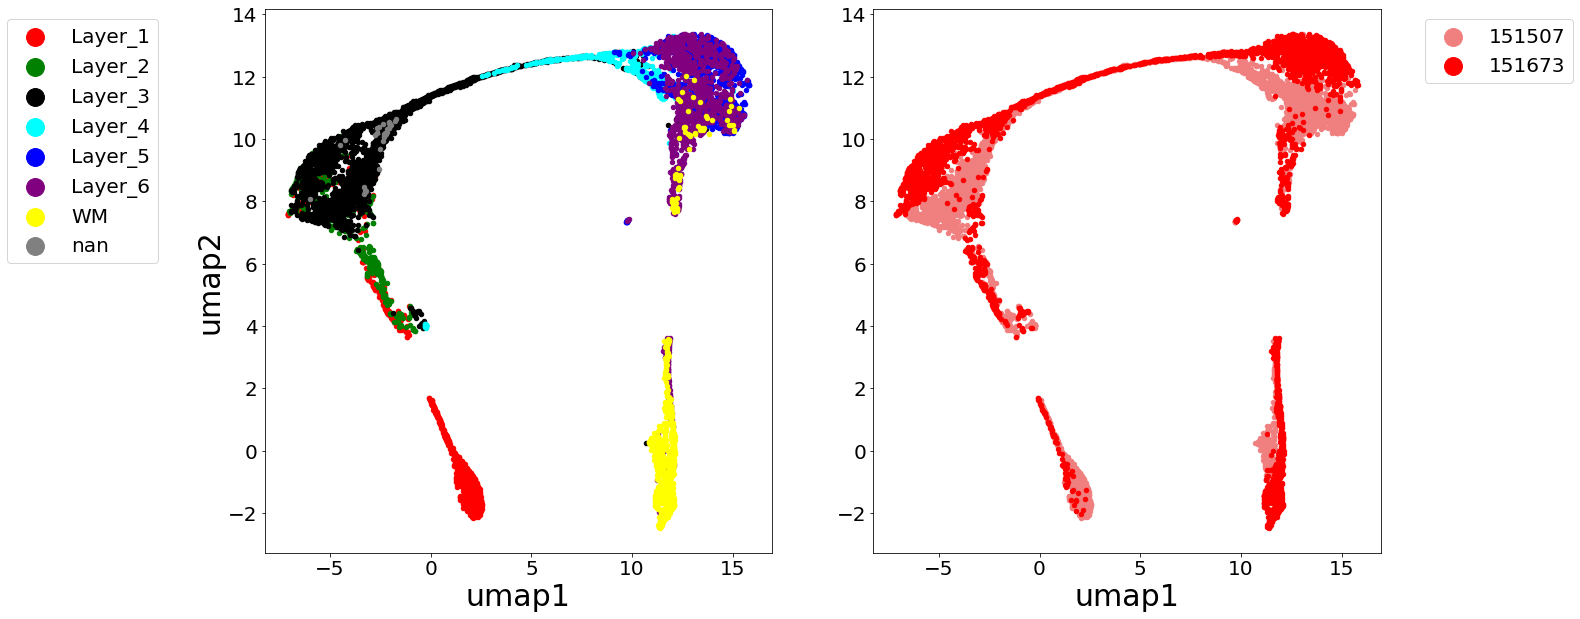

In [7]:
celltype=adata_h5.obs['layer_guess']
batch=adata_h5.obs['batch_label']
ul=np.unique(celltype)
ub=np.unique(batch)
umap_mat=umap.UMAP().fit_transform(sed_feat)
colour1=['r','g','black','cyan','blue','purple','yellow','grey']
colour2=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,2,figsize=(20,10))
size=20
for i in range(len(ul)):
    axs[0].scatter(umap_mat[np.where(celltype==ul[i])[0],0],umap_mat[np.where(celltype==ul[i])[0],1],c=colour1[i],s=size)

axs[0].set_xlabel("umap1",fontsize=30)
axs[0].set_ylabel("umap2",fontsize=30)
axs[0].legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs[0].tick_params(axis='both', which='major', labelsize=20)
for i in range(len(ub)):
    axs[1].scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour2[i],s=size)
axs[1].set_xlabel("umap1",fontsize=30)
axs[1].legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs[1].tick_params(axis='both', which='major', labelsize=20)

simluate

In [4]:
dirs="/data02/tguo/space_batch_effect/simulate/"
batch_sim="_1_2"
types="_3batch_types5"
for proj_idx in np.arange(1,4):
    feat=pd.read_csv(dirs+"gtt_input/feat"+str(proj_idx)+batch_sim+types+".csv",header=0,index_col=0,sep=',')
    meta=pd.read_csv(dirs+"gtt_input/meta"+str(proj_idx)+batch_sim+types+".csv",header=0,index_col=0,sep=',')
    coord=pd.read_csv(dirs+"gtt_input/coord"+str(proj_idx)+batch_sim+types+".csv",header=0,index_col=0,sep=',')
    adata_h5_tmp=anndata.AnnData(feat)
    adata_h5_tmp.obs['batch_label'] = meta.loc[adata_h5_tmp.obs_names,'batch']
    adata_h5_tmp.obs['layer_guess'] = meta.loc[adata_h5_tmp.obs_names,'celltype']
    adata_h5_tmp.obsm['spatial']=coord.loc[:,['x','y']].values
        
    graph_dict_tmp = graph_construction(adata_h5_tmp.obsm['spatial'], adata_h5_tmp.shape[0], params)
    if proj_idx == 1:
        adata_h5 = adata_h5_tmp
        graph_dict = graph_dict_tmp
        proj_name = str(proj_idx)
    else:
        var_names = adata_h5.var_names.intersection(adata_h5_tmp.var_names)
        adata_h5 = adata_h5[:, var_names]
        adata_h5_tmp = adata_h5_tmp[:, var_names]
        adata_h5 = adata_h5.concatenate(adata_h5_tmp)
        graph_dict = combine_graph_dict(graph_dict, graph_dict_tmp)
        proj_name = proj_name + '_' + str(proj_idx)
print('Combined adata: (' + str(adata_h5.shape[0]) + ', ' + str(adata_h5.shape[1]) + ')')

Combined adata: (846, 500)


In [5]:
params.cell_num = adata_h5.shape[0]
pca=PCA(n_components=params.cell_feat_dim)
pca.fit(adata_h5.X)
adata_X=pca.transform(adata_h5.X)
sed_net = SEDR_Train(adata_X, graph_dict, params)
if params.using_dec:
    sed_net.train_with_dec()
else:
    sed_net.train_without_dec()
sed_feat, _, _, _ = sed_net.process()
flags=batch_sim+types
cell_names=np.array(adata_h5.obs_names)
for i in range(adata_h5.shape[0]):
    cell_names[i]=adata_h5.obs_names[i].split('-')[0]
a=pd.DataFrame(sed_feat,index=cell_names,columns=['SEDR_'+str(i) for i in range(sed_feat.shape[1])])
a.to_csv(dirs+"methods/SEDR_mat"+flags+".csv")

GNN model train without DEC:  |################| 300 / 300 | Left time: 0.00 mins| Loss: 28.1729
Training Graph Net with DEC loss:  |################| 300 / 300 | Loss: 27.0896


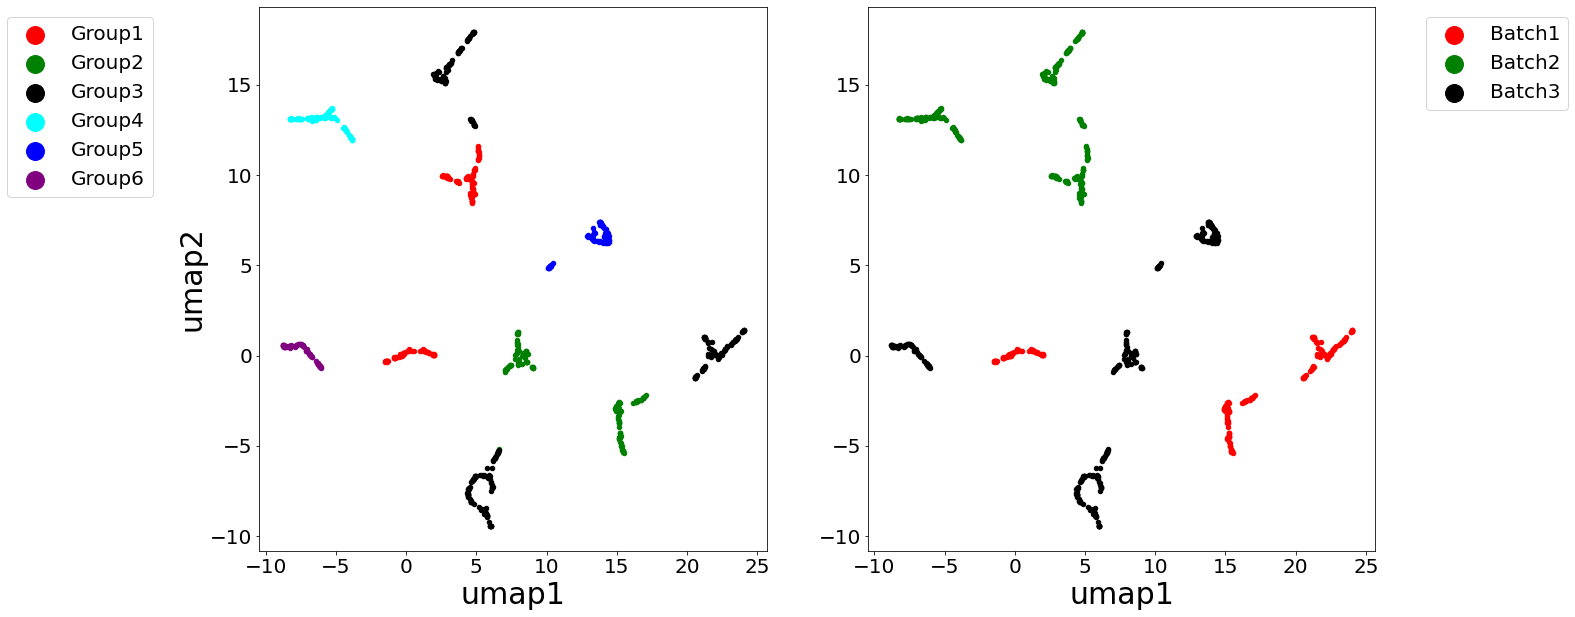

In [6]:
celltype=adata_h5.obs['layer_guess']
batch=adata_h5.obs['batch_label']
ul=np.unique(celltype)
ub=np.unique(batch)
umap_mat=umap.UMAP().fit_transform(sed_feat)
colour1=['r','g','black','cyan','blue','purple','yellow','grey']
colour2=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,2,figsize=(20,10))
size=20
for i in range(len(ul)):
    axs[0].scatter(umap_mat[np.where(celltype==ul[i])[0],0],umap_mat[np.where(celltype==ul[i])[0],1],c=colour1[i],s=size)

axs[0].set_xlabel("umap1",fontsize=30)
axs[0].set_ylabel("umap2",fontsize=30)
axs[0].legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs[0].tick_params(axis='both', which='major', labelsize=20)
for i in range(len(ub)):
    axs[1].scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour1[i],s=size)
axs[1].set_xlabel("umap1",fontsize=30)
axs[1].legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs[1].tick_params(axis='both', which='major', labelsize=20)

mouse brain

In [4]:
dirs="/data02/tguo/space_batch_effect/mouse_brain/"
# proj=["all_posterior1","all_posterior2","all_anterior1","all_anterior2"]
proj=["pa_anterior1","pa_posterior1"]
for proj_idx in np.arange(len(proj)):
    feat=pd.read_csv(dirs+"gtt_input/"+str(proj[proj_idx])+"_mat.csv",header=0,index_col=0,sep=',')
    meta=pd.read_csv(dirs+"gtt_input/"+str(proj[proj_idx])+"_meta.csv",header=0,index_col=0,sep=',')
    coord=pd.read_csv(dirs+"gtt_input/"+str(proj[proj_idx])+"_coord.csv",header=0,index_col=0,sep=',')
    adata_h5_tmp=anndata.AnnData(feat)
    adata_h5_tmp.obs['batch_label'] = meta.loc[adata_h5_tmp.obs_names,'batch']
    adata_h5_tmp.obs['layer_guess'] = meta.loc[adata_h5_tmp.obs_names,'celltype']
    adata_h5_tmp.obsm['spatial']=coord.loc[:,['x','y']].values
        
    graph_dict_tmp = graph_construction(adata_h5_tmp.obsm['spatial'], adata_h5_tmp.shape[0], params)
    if proj_idx == 0:
        adata_h5 = adata_h5_tmp
        graph_dict = graph_dict_tmp
        proj_name = str(proj_idx)
    else:
        var_names = adata_h5.var_names.intersection(adata_h5_tmp.var_names)
        adata_h5 = adata_h5[:, var_names]
        adata_h5_tmp = adata_h5_tmp[:, var_names]
        adata_h5 = adata_h5.concatenate(adata_h5_tmp)
        graph_dict = combine_graph_dict(graph_dict, graph_dict_tmp)
        proj_name = proj_name + '_' + str(proj_idx)
print('Combined adata: (' + str(adata_h5.shape[0]) + ', ' + str(adata_h5.shape[1]) + ')')

Combined adata: (6049, 5287)


In [5]:
params.cell_num = adata_h5.shape[0]
pca=PCA(n_components=params.cell_feat_dim)
pca.fit(adata_h5.X)
adata_X=pca.transform(adata_h5.X)
sed_net = SEDR_Train(adata_X, graph_dict, params)
if params.using_dec:
    sed_net.train_with_dec()
else:
    sed_net.train_without_dec()
sed_feat, _, _, _ = sed_net.process()

flags=''
for i in np.arange(len(proj)):
    flags=flags+'_'+proj[i]
cell_names=np.array(adata_h5.obs_names)
for i in range(adata_h5.shape[0]):
    cell_names[i]=adata_h5.obs_names[i].split('-')[0]+'-'+adata_h5.obs_names[i].split('-')[1]
a=pd.DataFrame(sed_feat,index=cell_names,columns=['SEDR_'+str(i) for i in range(sed_feat.shape[1])])
a.to_csv(dirs+"methods/SEDR_mat"+flags+"_1.csv")

GNN model train without DEC:  |################| 300 / 300 | Left time: 0.00 mins| Loss: 5.7699
Training Graph Net with DEC loss:  |################| 300 / 300 | Loss: 5.6928raining Graph Net with DEC loss:  |#               | 30 / 300 | Loss: 5.7697


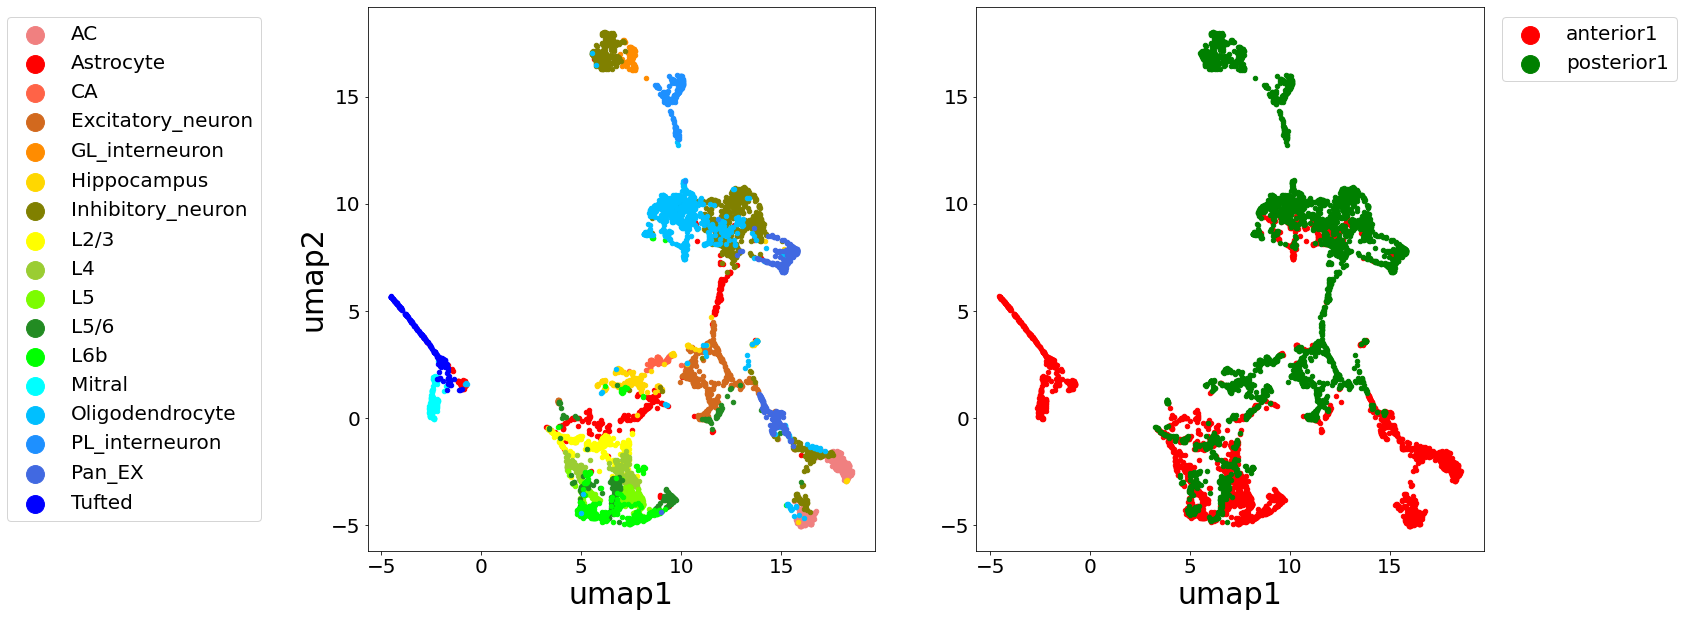

In [6]:
celltype=adata_h5.obs['layer_guess']
batch=adata_h5.obs['batch_label']
ul=np.unique(celltype)
ub=np.unique(batch)
umap_mat=umap.UMAP().fit_transform(sed_feat)
colour1=['r','g','black','cyan','blue','purple','yellow','grey']
colour2=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,2,figsize=(20,10))
size=20
for i in range(len(ul)):
    axs[0].scatter(umap_mat[np.where(celltype==ul[i])[0],0],umap_mat[np.where(celltype==ul[i])[0],1],c=colour2[i],s=size)

axs[0].set_xlabel("umap1",fontsize=30)
axs[0].set_ylabel("umap2",fontsize=30)
axs[0].legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs[0].tick_params(axis='both', which='major', labelsize=20)
for i in range(len(ub)):
    axs[1].scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour1[i],s=size)
axs[1].set_xlabel("umap1",fontsize=30)
axs[1].legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs[1].tick_params(axis='both', which='major', labelsize=20)

mouse OB

In [4]:
dirs="/data02/tguo/space_batch_effect/mouse_OB/"
# proj=["10X","BGI","SlideV2"]
proj=["BGI","SlideV2","10X"]
for proj_idx in np.arange(len(proj)):
    feat=pd.read_csv(dirs+"gtt_input/"+str(proj[proj_idx])+"_mat.csv",header=0,index_col=0,sep=',')
    meta=pd.read_csv(dirs+"gtt_input/"+str(proj[proj_idx])+"_meta.csv",header=0,index_col=0,sep=',')
    coord=pd.read_csv(dirs+"gtt_input/"+str(proj[proj_idx])+"_coord.csv",header=0,index_col=0,sep=',')
    adata_h5_tmp=anndata.AnnData(feat)
    adata_h5_tmp.obs['batch_label'] = meta.loc[adata_h5_tmp.obs_names,'batch']
    adata_h5_tmp.obs['layer_guess'] = meta.loc[adata_h5_tmp.obs_names,'celltype']
    adata_h5_tmp.obsm['spatial']=coord.loc[:,['x','y']].values
        
    graph_dict_tmp = graph_construction(adata_h5_tmp.obsm['spatial'], adata_h5_tmp.shape[0], params)
    if proj_idx == 0:
        adata_h5 = adata_h5_tmp
        graph_dict = graph_dict_tmp
        proj_name = str(proj_idx)
    else:
        var_names = adata_h5.var_names.intersection(adata_h5_tmp.var_names)
        adata_h5 = adata_h5[:, var_names]
        adata_h5_tmp = adata_h5_tmp[:, var_names]
        adata_h5 = adata_h5.concatenate(adata_h5_tmp)
        graph_dict = combine_graph_dict(graph_dict, graph_dict_tmp)
        proj_name = proj_name + '_' + str(proj_idx)
print('Combined adata: (' + str(adata_h5.shape[0]) + ', ' + str(adata_h5.shape[1]) + ')')

Combined adata: (28549, 5531)


In [5]:
params.cell_num = adata_h5.shape[0]
pca=PCA(n_components=params.cell_feat_dim)
pca.fit(adata_h5.X)
adata_X=pca.transform(adata_h5.X)
sed_net = SEDR_Train(adata_X, graph_dict, params)
if params.using_dec:
    sed_net.train_with_dec()
else:
    sed_net.train_without_dec()
sed_feat, _, _, _ = sed_net.process()
flags="_"+proj[0]
for i in np.arange(1,len(proj)):
    flags=flags+"_"+proj[i]
    

meta=pd.read_csv(dirs+"gtt_input/"+str(proj[0])+"_meta.csv",header=0,index_col=0,sep=',')
for proj_idx in np.arange(1,len(proj)):
    meta=pd.concat((meta,pd.read_csv(dirs+"gtt_input/"+str(proj[proj_idx])+"_meta.csv",header=0,index_col=0,sep=',')))

cell_names=np.array(adata_h5.obs_names)
for i in range(adata_h5.shape[0]):
    cell_names[i]=adata_h5.obs_names[i].split('-')[0]+'-'+adata_h5.obs_names[i].split('-')[1]+'-'+adata_h5.obs_names[i].split('-')[2]
a=pd.DataFrame(sed_feat,index=meta.index,columns=['SEDR_'+str(i) for i in range(sed_feat.shape[1])])
a.to_csv(dirs+"methods/SEDR_mat"+flags+".csv")

GNN model train without DEC:  |################| 300 / 300 | Left time: 0.06 mins| Loss: 13.15595
Training Graph Net with DEC loss:  |################| 300 / 300 | Loss: 13.2076


ValueError: Shape of passed values is (28549, 28), indices imply (19722, 28)

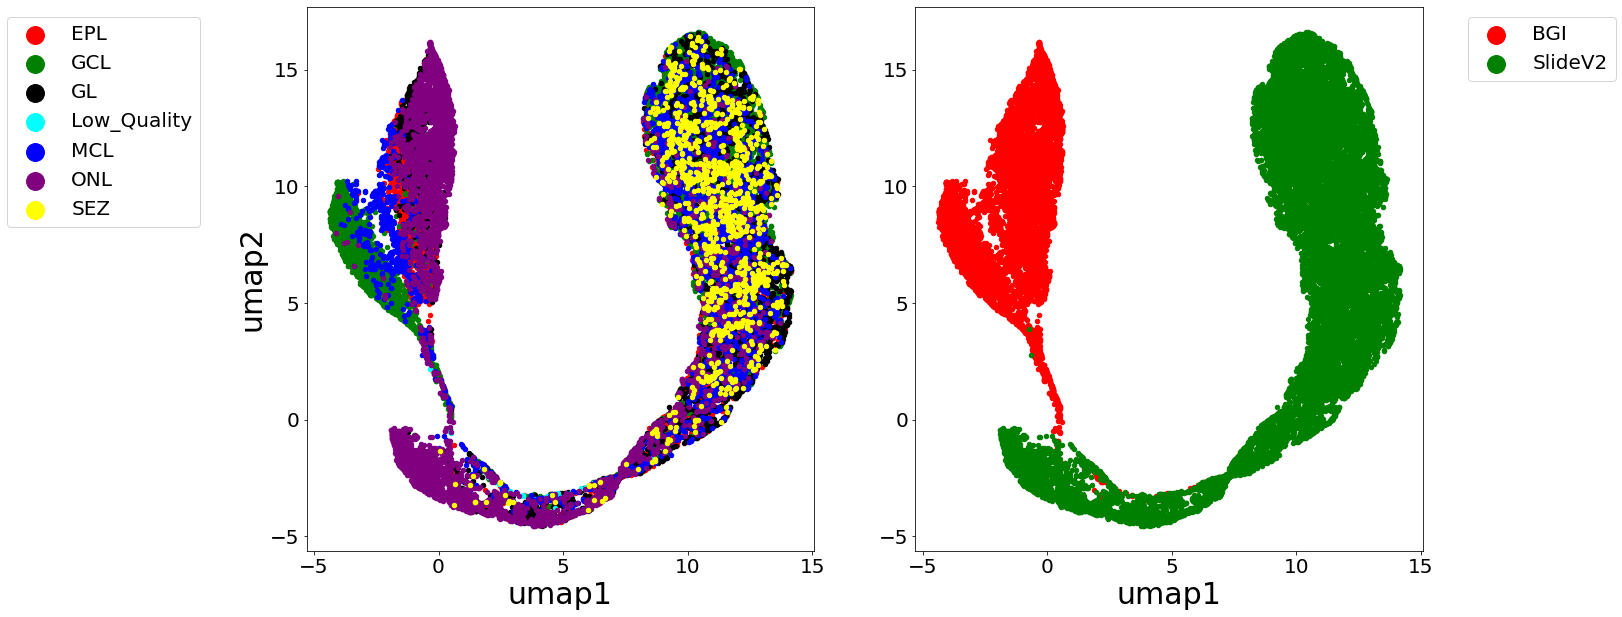

In [15]:
celltype=adata_h5.obs['layer_guess']
batch=adata_h5.obs['batch_label']
ul=np.unique(celltype)
ub=np.unique(batch)
# umap_mat=umap.UMAP().fit_transform(sed_feat)
colour1=['r','g','black','cyan','blue','purple','yellow','grey']
colour2=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,2,figsize=(20,10))
size=20
for i in range(len(ul)):
    axs[0].scatter(umap_mat[np.where(celltype==ul[i])[0],0],umap_mat[np.where(celltype==ul[i])[0],1],c=colour1[i],s=size)

axs[0].set_xlabel("umap1",fontsize=30)
axs[0].set_ylabel("umap2",fontsize=30)
axs[0].legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs[0].tick_params(axis='both', which='major', labelsize=20)
for i in range(len(ub)):
    axs[1].scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour1[i],s=size)
axs[1].set_xlabel("umap1",fontsize=30)
axs[1].legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs[1].tick_params(axis='both', which='major', labelsize=20)

hippo

In [4]:
dirs="/data02/tguo/space_batch_effect/Hippo/"
proj=["10X_Normal","10X_DAPI","10X_FFPE"]
for proj_idx in np.arange(len(proj)):
    feat=pd.read_csv(dirs+"gtt_input/"+str(proj[proj_idx])+"_allgene_mat.csv",header=0,index_col=0,sep=',')
    meta=pd.read_csv(dirs+"gtt_input/"+str(proj[proj_idx])+"_meta.csv",header=0,index_col=0,sep=',')
    coord=pd.read_csv(dirs+"gtt_input/"+str(proj[proj_idx])+"_coord.csv",header=0,index_col=0,sep=',')
    adata_h5_tmp=anndata.AnnData(feat)
    adata_h5_tmp.obs['batch_label'] = meta.loc[adata_h5_tmp.obs_names,'batch']
    adata_h5_tmp.obs['layer_guess'] = meta.loc[adata_h5_tmp.obs_names,'celltype']
    adata_h5_tmp.obsm['spatial']=coord.loc[:,['x','y']].values
        
    graph_dict_tmp = graph_construction(adata_h5_tmp.obsm['spatial'], adata_h5_tmp.shape[0], params)
    if proj_idx == 0:
        adata_h5 = adata_h5_tmp
        graph_dict = graph_dict_tmp
        proj_name = str(proj_idx)
    else:
        var_names = adata_h5.var_names.intersection(adata_h5_tmp.var_names)
        adata_h5 = adata_h5[:, var_names]
        adata_h5_tmp = adata_h5_tmp[:, var_names]
        adata_h5 = adata_h5.concatenate(adata_h5_tmp)
        graph_dict = combine_graph_dict(graph_dict, graph_dict_tmp)
        proj_name = proj_name + '_' + str(proj_idx)
print('Combined adata: (' + str(adata_h5.shape[0]) + ', ' + str(adata_h5.shape[1]) + ')')

Combined adata: (7869, 19465)


In [15]:
adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)
params.cell_num = adata_h5.shape[0]
sed_net = SEDR_Train(adata_X, graph_dict, params)
if params.using_dec:
    sed_net.train_with_dec()
else:
    sed_net.train_without_dec()
sed_feat, _, _, _ = sed_net.process()
flags="_"+proj[0]
for i in np.arange(1,len(proj)):
    flags=flags+"_"+proj[i]
cell_names=np.array(adata_h5.obs_names)
for i in range(adata_h5.shape[0]):
    cell_names[i]=adata_h5.obs_names[i].split('-')[0]+'-'+adata_h5.obs_names[i].split('-')[1]+'-'+adata_h5.obs_names[i].split('-')[2]
a=pd.DataFrame(sed_feat,index=cell_names,columns=['SEDR_'+str(i) for i in range(sed_feat.shape[1])])
a.to_csv(dirs+"methods/SEDR_mat"+flags+".csv")

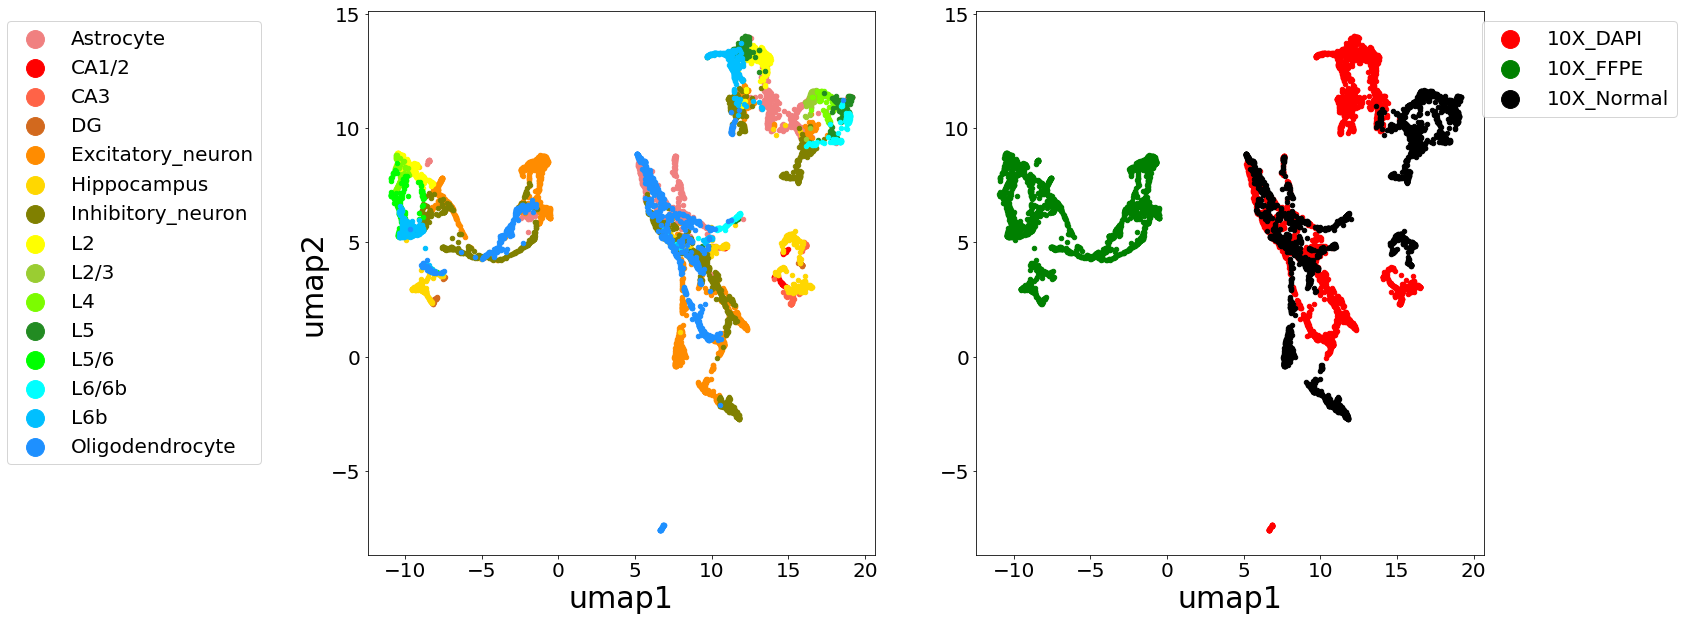

In [17]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
celltype=adata_h5.obs['layer_guess']
batch=adata_h5.obs['batch_label']
ul=np.unique(celltype)
ub=np.unique(batch)
umap_mat=umap.UMAP().fit_transform(sed_feat)
colour2=['r','g','black','cyan','blue','purple','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,2,figsize=(20,10))
size=20
for i in range(len(ul)):
    axs[0].scatter(umap_mat[np.where(celltype==ul[i])[0],0],umap_mat[np.where(celltype==ul[i])[0],1],c=colour1[i],s=size)

axs[0].set_xlabel("umap1",fontsize=30)
axs[0].set_ylabel("umap2",fontsize=30)
axs[0].legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs[0].tick_params(axis='both', which='major', labelsize=20)
for i in range(len(ub)):
    axs[1].scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour2[i],s=size)
axs[1].set_xlabel("umap1",fontsize=30)
axs[1].legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs[1].tick_params(axis='both', which='major', labelsize=20)

PDAC

In [26]:
dirs="/data02/tguo/space_batch_effect/PDAC/"
proj=["PDAC-A-ST1","PDAC-B-ST1","PDAC-D-ST1","PDAC-E-ST1","PDAC-G-ST1"]
for proj_idx in np.arange(len(proj)):
    feat=pd.read_csv(dirs+"gtt_input/"+str(proj[proj_idx])+"_allgene_mat.csv",header=0,index_col=0,sep=',')
    coord=pd.read_csv(dirs+"gtt_input/"+str(proj[proj_idx])+"_coord.csv",header=0,index_col=0,sep=',')
    adata_h5_tmp=anndata.AnnData(feat)
    adata_h5_tmp.obsm['spatial']=coord.loc[:,['x','y']].values
    graph_dict_tmp = graph_construction(adata_h5_tmp.obsm['spatial'], adata_h5_tmp.shape[0], params)
    if proj_idx == 0:
        adata_h5 = adata_h5_tmp
        graph_dict = graph_dict_tmp
        proj_name = str(proj_idx)
    else:
        var_names = adata_h5.var_names.intersection(adata_h5_tmp.var_names)
        adata_h5 = adata_h5[:, var_names]
        adata_h5_tmp = adata_h5_tmp[:, var_names]
        adata_h5 = adata_h5.concatenate(adata_h5_tmp)
        graph_dict = combine_graph_dict(graph_dict, graph_dict_tmp)
        proj_name = proj_name + '_' + str(proj_idx)
print('Combined adata: (' + str(adata_h5.shape[0]) + ', ' + str(adata_h5.shape[1]) + ')')

Combined adata: (1728, 19738)


In [27]:
adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)
params.cell_num = adata_h5.shape[0]
sed_net = SEDR_Train(adata_X, graph_dict, params)
if params.using_dec:
    sed_net.train_with_dec()
else:
    sed_net.train_without_dec()
sed_feat, _, _, _ = sed_net.process()
flags="_"+proj[0]
for i in np.arange(1,len(proj)):
    flags=flags+"_"+proj[i]
cell_names=np.array(adata_h5.obs_names)
for i in range(adata_h5.shape[0]):
    cell_names[i]=adata_h5.obs_names[i].split('-')[0]+'-'+adata_h5.obs_names[i].split('-')[1]+'-'+adata_h5.obs_names[i].split('-')[2]+'-'+adata_h5.obs_names[i].split('-')[3]
a=pd.DataFrame(sed_feat,index=cell_names,columns=['SEDR_'+str(i) for i in range(sed_feat.shape[1])])
a.to_csv(dirs+"methods/SEDR_mat"+flags+".csv")

===== Preprocessing Data 


GNN model train without DEC:  |################| 300 / 300 | Left time: 0.00 mins| Loss: 177.0736NN model train without DEC:  |###             | 68 / 300 | Left time: 0.07 mins| Loss: 182.8872GNN model train without DEC:  |#####           | 107 / 300 | Left time: 0.06 mins| Loss: 180.9472GNN model train without DEC:  |#####           | 108 / 300 | Left time: 0.06 mins| Loss: 181.0789GNN model train without DEC:  |######          | 131 / 300 | Left time: 0.04 mins| Loss: 179.7063GNN model train without DEC:  |########        | 163 / 300 | Left time: 0.03 mins| Loss: 179.0719GNN model train without DEC:  |############    | 237 / 300 | Left time: 0.01 mins| Loss: 177.2363
Training Graph Net with DEC loss:  |################| 300 / 300 | Loss: 178.7432raining Graph Net with DEC loss:  |####            | 81 / 300 | Loss: 179.3823Training Graph Net with DEC loss:  |####            | 83 / 300 | Loss: 179.5780Training Graph Net with DEC loss:  |#####           | 100 / 300 | Loss: 178.1292Train

breas_cancer

In [44]:
dirs="/data02/tguo/space_batch_effect/breast_cancer/"
# proj=["A-A1","A-A2","A-A3","A-A4","A-A5","A-A6"]
proj=['10X-1','10X-2']
for proj_idx in np.arange(len(proj)):
    feat=pd.read_csv(dirs+"gtt_input/"+str(proj[proj_idx])+"_allgene_mat.csv",header=0,index_col=0,sep=',')
    coord=pd.read_csv(dirs+"gtt_input/"+str(proj[proj_idx])+"_coord.csv",header=0,index_col=0,sep=',')
    adata_h5_tmp=anndata.AnnData(feat)
    adata_h5_tmp.obsm['spatial']=coord.loc[:,['x','y']].values
    graph_dict_tmp = graph_construction(adata_h5_tmp.obsm['spatial'], adata_h5_tmp.shape[0], params)
    if proj_idx == 0:
        adata_h5 = adata_h5_tmp
        graph_dict = graph_dict_tmp
        proj_name = str(proj_idx)
    else:
        var_names = adata_h5.var_names.intersection(adata_h5_tmp.var_names)
        adata_h5 = adata_h5[:, var_names]
        adata_h5_tmp = adata_h5_tmp[:, var_names]
        adata_h5 = adata_h5.concatenate(adata_h5_tmp)
        graph_dict = combine_graph_dict(graph_dict, graph_dict_tmp)
        proj_name = proj_name + '_' + str(proj_idx)
print('Combined adata: (' + str(adata_h5.shape[0]) + ', ' + str(adata_h5.shape[1]) + ')')

Combined adata: (7785, 36601)


In [45]:
adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)
params.cell_num = adata_h5.shape[0]
sed_net = SEDR_Train(adata_X, graph_dict, params)
if params.using_dec:
    sed_net.train_with_dec()
else:
    sed_net.train_without_dec()
sed_feat, _, _, _ = sed_net.process()
flags="_"+proj[0]
for i in np.arange(1,len(proj)):
    flags=flags+"_"+proj[i]
cell_names=np.array(adata_h5.obs_names)
for i in range(adata_h5.shape[0]):
#     cell_names[i]=adata_h5.obs_names[i].split('-')[0]+'-'+adata_h5.obs_names[i].split('-')[1]
    cell_names[i]=adata_h5.obs_names[i].split('-')[0]+'-'+adata_h5.obs_names[i].split('-')[1]+'-'+adata_h5.obs_names[i].split('-')[2]
a=pd.DataFrame(sed_feat,index=cell_names,columns=['SEDR_'+str(i) for i in range(sed_feat.shape[1])])
a.to_csv(dirs+"methods/SEDR_mat"+flags+".csv")

===== Preprocessing Data 


GNN model train without DEC:  |################| 300 / 300 | Left time: 0.00 mins| Loss: 143.4297
Training Graph Net with DEC loss:  |################| 300 / 300 | Loss: 141.9541


MOSTA

In [4]:
dirs="/data02/tguo/space_batch_effect/MOSTA/"
proj=["E9.5","E10.5"]
for proj_idx in np.arange(len(proj)):
    feat=pd.read_csv(dirs+"gtt_input/"+str(proj[proj_idx])+"_mat.csv",header=0,index_col=0,sep=',')
    coord=pd.read_csv(dirs+"gtt_input/"+str(proj[proj_idx])+"_coord.csv",header=0,index_col=0,sep=',')
    adata_h5_tmp=anndata.AnnData(feat)
    adata_h5_tmp.obsm['spatial']=coord.loc[:,['x','y']].values
    graph_dict_tmp = graph_construction(adata_h5_tmp.obsm['spatial'], adata_h5_tmp.shape[0], params)
    if proj_idx == 0:
        adata_h5 = adata_h5_tmp
        graph_dict = graph_dict_tmp
        proj_name = str(proj_idx)
    else:
        var_names = adata_h5.var_names.intersection(adata_h5_tmp.var_names)
        adata_h5 = adata_h5[:, var_names]
        adata_h5_tmp = adata_h5_tmp[:, var_names]
        adata_h5 = adata_h5.concatenate(adata_h5_tmp)
        graph_dict = combine_graph_dict(graph_dict, graph_dict_tmp)
        proj_name = proj_name + '_' + str(proj_idx)
print('Combined adata: (' + str(adata_h5.shape[0]) + ', ' + str(adata_h5.shape[1]) + ')')

Combined adata: (24321, 3795)


In [5]:
adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)
params.cell_num = adata_h5.shape[0]
sed_net = SEDR_Train(adata_X, graph_dict, params)
if params.using_dec:
    sed_net.train_with_dec()
else:
    sed_net.train_without_dec()
sed_feat, _, _, _ = sed_net.process()
flags="_"+proj[0]
for i in np.arange(1,len(proj)):
    flags=flags+"_"+proj[i]
cell_names=np.array(adata_h5.obs_names)
for i in range(adata_h5.shape[0]):
#     cell_names[i]=adata_h5.obs_names[i].split('-')[0]+'-'+adata_h5.obs_names[i].split('-')[1]
    cell_names[i]=adata_h5.obs_names[i].split('-')[0]+'-'+adata_h5.obs_names[i].split('-')[1]
a=pd.DataFrame(sed_feat,index=cell_names,columns=['SEDR_'+str(i) for i in range(sed_feat.shape[1])])
a.to_csv(dirs+"methods/SEDR_mat"+flags+".csv")

===== Preprocessing Data 


GNN model train without DEC:  |################| 300 / 300 | Left time: 0.06 mins| Loss: 39.10208
Training Graph Net with DEC loss:  |################| 300 / 300 | Loss: 38.9544
